In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets
from sklearn.linear_model import LogisticRegression

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [2]:
dataset_orig = pd.read_csv('../../../data/compas-scores-two-years.csv')

## Removed two duplicate coumns - 'decile_score','priors_count'
dataset_orig = dataset_orig.drop(['id','name','first','last','compas_screening_date',
                                  'dob','age','juv_fel_count','decile_score',
                                  'juv_misd_count','juv_other_count','days_b_screening_arrest',
                                  'c_jail_in','c_jail_out','c_case_number','c_offense_date','c_arrest_date',
                                  'c_days_from_compas','c_charge_desc','is_recid','r_case_number','r_charge_degree',
                                  'r_days_from_arrest','r_offense_date','r_charge_desc','r_jail_in','r_jail_out',
                                  'violent_recid','is_violent_recid','vr_case_number','vr_charge_degree','vr_offense_date',
                                  'vr_charge_desc','type_of_assessment','decile_score','score_text','screening_date',
                                  'v_type_of_assessment','v_decile_score','v_score_text','v_screening_date','in_custody',
                                  'out_custody','start','end','event'],axis=1)

## Drop NULL values
dataset_orig = dataset_orig.dropna()

dataset_orig.rename(index=str, columns={"two_year_recid": "Probability"}, inplace=True)
dataset_orig['Probability'] = np.where(dataset_orig['Probability'] == 0, 1, 0)
dataset_orig['sex'] = np.where(dataset_orig['sex'] == 'Female', 1, 0)
dataset_orig['race'] = np.where(dataset_orig['race'] != 'Caucasian', 0, 1)

non_numeric_columns = list(dataset_orig.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    dataset_orig[col] = le.fit_transform(dataset_orig[col])

print(non_numeric_columns)

from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)

# divide the data based on protected_attribute
protected_attribute = "race"
dataset_orig_male , dataset_orig_female = [x for _, x in dataset_orig.groupby(dataset_orig[protected_attribute] == 0)]

print(dataset_orig.head(5))

['age_cat', 'c_charge_degree']
   sex  age_cat  race  priors_count  c_charge_degree  Probability
0  0.0      0.5   0.0      0.000000              0.0          1.0
1  0.0      0.0   0.0      0.000000              0.0          0.0
2  0.0      1.0   0.0      0.105263              0.0          0.0
3  0.0      1.0   0.0      0.026316              0.0          1.0
4  0.0      0.0   0.0      0.052632              0.0          1.0


# Fairway

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy
protected_attribute = 'sex'

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=0)
X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']

dataset_orig_male , dataset_orig_female = [x for _, x in dataset_orig_train.groupby(dataset_orig_train[protected_attribute] == 0)]
dataset_orig_male[protected_attribute] = 0
X_train_male, y_train_male = dataset_orig_male.loc[:, dataset_orig_male.columns != 'Probability'], dataset_orig_male['Probability']
clf_male = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_male.fit(X_train_male, y_train_male)
X_train_female, y_train_female = dataset_orig_female.loc[:, dataset_orig_female.columns != 'Probability'], dataset_orig_female['Probability']
clf_female = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_female.fit(X_train_female, y_train_female)

for index,row in dataset_orig_train.iterrows():
    row_ = [row.values[0:len(row.values)-1]]
    y_male = clf_male.predict(row_)
    y_female = clf_female.predict(row_)
    if y_male[0] != y_female[0]:        
        dataset_orig_train = dataset_orig_train.drop(index)

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

aod :sex -0.08
eod :sex 0.13
SPD: 0.22
DI: 0.24
aod :sex -0.07
eod :sex 0.08
SPD: 0.15
DI: 0.16


# Graph

In [26]:
causal_graph = """
digraph {
sex;
age_cat;
race;
priors_count;
c_charge_degree;
Probability;
U[label="Unobserved Confounders"];
sex -> Probability;
sex -> age_cat; age_cat -> Probability;
race -> Probability;
sex -> c_charge_degree; c_charge_degree -> Probability;
U->sex;U->race;U->Probability;
}
"""

## dowhy works for binary inputs only

dataset_orig['Probability'] = np.where(dataset_orig['Probability'] == 0, False, True)
dataset_orig[protected_attribute] = np.where(dataset_orig[protected_attribute] == 1, True, False)

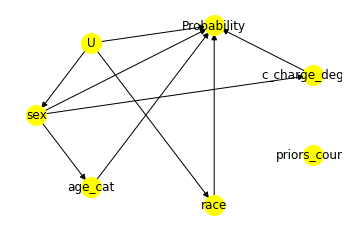

In [27]:
# With graph
model=CausalModel(
        data = dataset_orig,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [28]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                      
───────(Expectation(Probability|c_charge_degree,priors_count,sex,age_cat))
d[race]                                                                   
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,c_charge_degree,priors_count,sex,age_cat,U) = P(Probability|race,c_charge_degree,priors_count,sex,age_cat)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [30]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                      
───────(Expectation(Probability|c_charge_degree,priors_count,sex,age_cat))
d[race]                                                                   
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,c_charge_degree,priors_count,sex,age_cat,U) = P(Probability|race,c_charge_degree,priors_count,sex,age_cat)

## Realized estimand
b: Probability~race+c_charge_degree+priors_count+sex+age_cat
Target units: ate

## Estimate
Mean value: -0.0030853387994182343

Causal Estimate is -0.0030853387994182343


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [36]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:-0.0030853387994182343
New effect:-0.017025614951947207



# Replace Treatment with Placebo

In [35]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:-0.0030853387994182343
New effect:0.001068105117993783
p value:0.49



# Remove Random Subset of Data

In [37]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:-0.0030853387994182343
New effect:-0.0043448992716051535
p value:0.4

